## Numerical Differentiation using finite-differences

In [11]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import cm
import seaborn as sns
from scipy.integrate import quad
sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.set_style("whitegrid")
import sympy as sp
from IPython.display import HTML
from matplotlib import animation
%matplotlib inline

# Don't tinker, or do
#%matplotlib nbagg
# from matplotlib import rcParams
#rcParams['font.family']='sans-serif' 
#rcParams('font', serif='Helvetica Neue') 
# rcParams['text.usetex']= True 
#rcParams.update({'font.size': 22})

## Numerical differentiation schemes
Differentiation is another fundamental operation in calculus, and involves finding the slope of a certain curve (geometrically) at some point. This corresponds to the rate of change (or expected growth or decay of the function). We look at some schemes/algorithms to do estimate the slope, similar to our time-stepper lecture. The problem we deal with is then to approximate
$$  \frac{df}{dx}(x) \approx \sum_{i=1}^{n} \omega_i f(x_i) $$
given at least a \( C^{1} \) function $f : [a,b] \to \mathbb{R}$ with *nodes* ($x_i$) and *weights* ($\omega_i$). Schemes that we will be discussing involve careful choices of these nodes and weights. 

To get started, let us define a class that helps us implement any quadrature rule easily.

In [12]:
class SpatialDifferentiator(object):
    """ Class for wrapping a diff scheme with other goodies
    """
    def __init__(self, i_a, i_b, i_h):
        """ Initialize the Differentiator
        """
        # What forcing function are we using?
        self.forcing = None

        # What differentation algorithm are we using?
        self.differentiator = None

        self.a = i_a
        self.b = i_b
        self.h = i_h
        self.nsteps = int((i_b - i_a)/i_h)

    def set_forcing_function(self, t_func):
        """ Set forcing function to be used 
        """
        if type(t_func) is not str:
            try:
                # If not string, try and evaluate the function
                t_func(0.0)
                # If the function works, set this function as forcing
                self.forcing = t_func
            except:
                raise RuntimeError('Provided function cannot be evaluated')
        
    def analytic(self, x):
        """  For testing convergence, defined as a special function """
        analytical_differential = (self.forcing(x)[1])
        return analytical_differential
            
    def diff_using(self, differentiator, renderer):
        """  Differentiates the function and spits out the relative error
        """
        self.differentiator = differentiator.__name__
        # Periodic domain, b not included
        all_x = np.linspace(self.a, self.b, self.nsteps, endpoint=False)
        differential = differentiator(self.forcing, all_x, self.h)
        
        analytic_differential = self.analytic(all_x)
        # print("Integral is {:20.16f}, Analytical integral is {:20.16f}, Error is {:20.16f}".format(integral, analytical_integral, np.abs(integral - analytical_integral)))

        # Pass as (2xn) arrays. While reshaping do T to get (nx2) arrays
        self.draw(renderer, np.hstack((all_x, [self.b])), np.hstack((differential, differential[0])))
        err = np.max(np.abs((analytic_differential - differential))) / np.max(np.abs(analytic_differential))
        return err

    def draw(self, renderer, eval_x, num_diff):
        """ Draw the matplotlib canvas with the portrait we want
        """
        # If there is a timestepper, then there is numerical data
        # Plot them
        renderer.plot(eval_x, self.forcing(eval_x)[0], 'g-', label=r'$f(x)$')
        renderer.plot(eval_x, self.forcing(eval_x)[1], 'r-', label=r'$\frac{df(x)}{dx}$') 
        renderer.plot(eval_x, num_diff, label=r'Numerical')
        renderer.legend()
        renderer.set_xlabel(r'$x$')
        renderer.set_ylabel(r'$y$')
        renderer.set_title('{}'.format(self.differentiator))
        # renderer.set_aspect('equal')

## Finite-difference differentiation

A variety of rules for differentiation exist, obtained by mainpulating the Taylor series expansion around the point of interest. We look to approximate the slope (first order of diff) and the curvature (second order of differentiation) using many types of schemes: (a) Forward (b) Backward and (c) Central differences, although others (spectral) will be discussed on the way. We will attempt to compare these methods in terms of their ease (in understanding/implementation), order of accuracy (in comparison to the discretization $h$) and function evaluations for each step $h$.

## What do these rules do?
They approximate the slope of the curve in a smart way---using local polynomials (in the case of finite-differences), you approximate the curve and differentiate these polynomials instead. We'll first look at some  schemes for obtaining first order derivatives.

We first look at two point derivatives (i.e. only two function evaluations to estimate the derivative)

In [13]:
def fdiff_oneorder_twopoint(func, x, h):
    """Does forward differences to approximate the slope
    in a periodic domain
    
    Parameters
    ----------
    func : ufunc
        A function, f, that takes one argument and
        returns the function value and exact differential
        as a tuple
    x : float/array-like
        Points at which the function is sampled
    h : float/array-like
        The spacing between nodes

    Returns
    -------
    differential : float/array-like
        Approximation of the diff using quadrature
    """
    # Evaluate function
    fx = func(x)[0]
    
    # Periodic domain
    # (f(i+1)-f(i))/h
    df_dx = (np.roll(fx, -1) - fx) / (h)

    return df_dx

def bdiff_oneorder_twopoint(func, x, h):
    """Does backward differences to approximate the slope
    in a periodic domain
    
    Parameters
    ----------
    func : ufunc
        A function, f, that takes one argument and
        returns the function value and exact differential
        as a tuple
    x : float/array-like
        Points at which the function is sampled
    h : float/array-like
        The spacing between nodes

    Returns
    -------
    differential : float/array-like
        Approximation of the diff using quadrature
    """
    # Evaluate function
    fx = func(x)[0]
    
    # Periodic domain
    # (f(i)-f(i-1))/h
    df_dx = (fx - np.roll(fx, 1)) / (h)

    return df_dx

def cdiff_oneorder_twopoint(func, x, h):
    """Does centered differences to approximate the slope
    in a periodic domain
    
    Parameters
    ----------
    func : ufunc
        A function, f, that takes one argument and
        returns the function value and exact differential
        as a tuple
    x : float/array-like
        Points at which the function is sampled
    h : float/array-like
        The spacing between nodes

    Returns
    -------
    differential : float/array-like
        Approximation of the diff using quadrature
    """
    # Evaluate function
    fx = func(x)[0]
    
    # Periodic domain
    # (f(i+1)-f(i-1))/2h    
    df_dx = (np.roll(fx, -1) - np.roll(fx, 1)) / (2*h)

    return df_dx

## Testing diff?
Let's test these rules out between $[a,b]$ for simple periodic functions (trigonometric) curves and draw inferences from them (the error and so on...). The choice of periodic domain is not arbitrary---we do not need to worry about boundary conditions and so on...

In [14]:
# Bounds of function definition
a = 0
b = 1

# Step size of differentiation - change
# h = (b-a)/1
# h = (b-a)/20
h = (b-a)/100

# Define the periodic function to be differentiated and
# its exact differential - change
def periodic_func(x):
#     # Periodic function
#     return np.sin(2.*np.pi*x), 2.*np.pi*np.cos(2.*np.pi*x)

    
    # Periodic function
    k = 5
    return np.sin(2.*np.pi*k*x), 2.*np.pi*k*np.cos(2.*np.pi*k*x)

0.01636835691653945

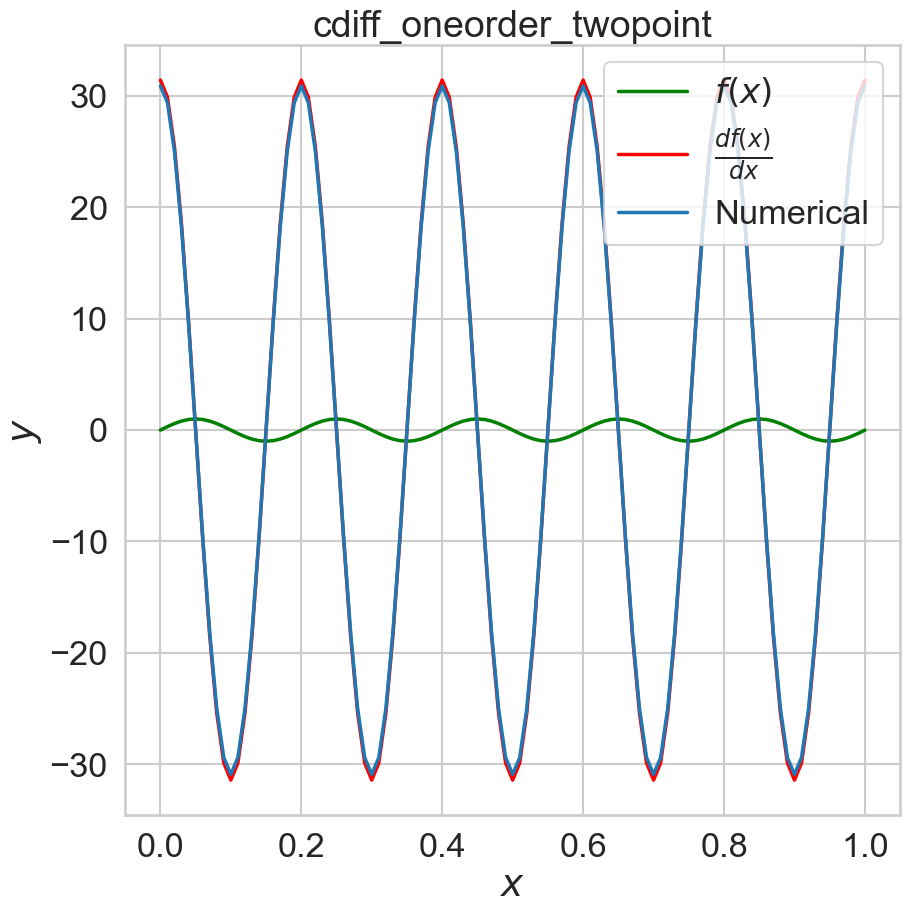

In [15]:
fig, ax = plt.subplots(1,1, figsize=(10, 10))
si = SpatialDifferentiator(a, b, h)
si.set_forcing_function(periodic_func)

# Differnt schemes, change
# si.diff_using(fdiff_oneorder_twopoint, ax)
# si.diff_using(bdiff_oneorder_twopoint, ax)
si.diff_using(cdiff_oneorder_twopoint, ax)

### Things to observe
- How does the spacing $h$ affect the derivative (visually)
- What about the choice of function?
- How do the central/backward/forward schemes compare?

## Higher order approximations
We then look at six point schemes to estimate the first derivative (i.e. six function evaluations to estimate the derivative). Look at https://en.wikipedia.org/wiki/Finite_difference_coefficient or http://web.media.mit.edu/~crtaylor/calculator.html for obtaining the coefficients in such schemes.

In [16]:
def fdiff_oneorder_sixpoint(func, x, h):
    # Evaluate function
    fx = func(x)[0]
    
    # Periodic domain
    df_dx = (-137.*fx + 300.*np.roll(fx, -1) - 300.*np.roll(fx, -2) + 200.*np.roll(fx, -3) - 75.*np.roll(fx, -4) + 12.*np.roll(fx, -5)) / (60.*h)
    
    return df_dx

def bdiff_oneorder_sixpoint(func, x, h):
    # Evaluate function
    fx = func(x)[0]
    
    # Periodic domain
    df_dx = (137.*fx - 300.*np.roll(fx, 1) + 300.*np.roll(fx, 2) - 200.*np.roll(fx, 3) + 75.*np.roll(fx, 4) - 12.*np.roll(fx, 5)) / (60.*h)
    
    return df_dx

def cdiff_oneorder_sixpoint(func, x, h):
    # Evaluate function
    fx = func(x)[0]
    
    # Periodic domain
    df_dx = (-np.roll(fx, 3) + 9. * np.roll(fx, 2) - 45. * np.roll(fx, 1) + 45. * np.roll(fx, -1) - 9. * np.roll(fx, -2) + np.roll(fx, -3) ) / (60.0 * h)
   
    return df_dx

In [17]:
# Bounds of function definition
a = 0
b = 1

# Step size of differentiation
h = (b-a)/16

0.19266670456496013

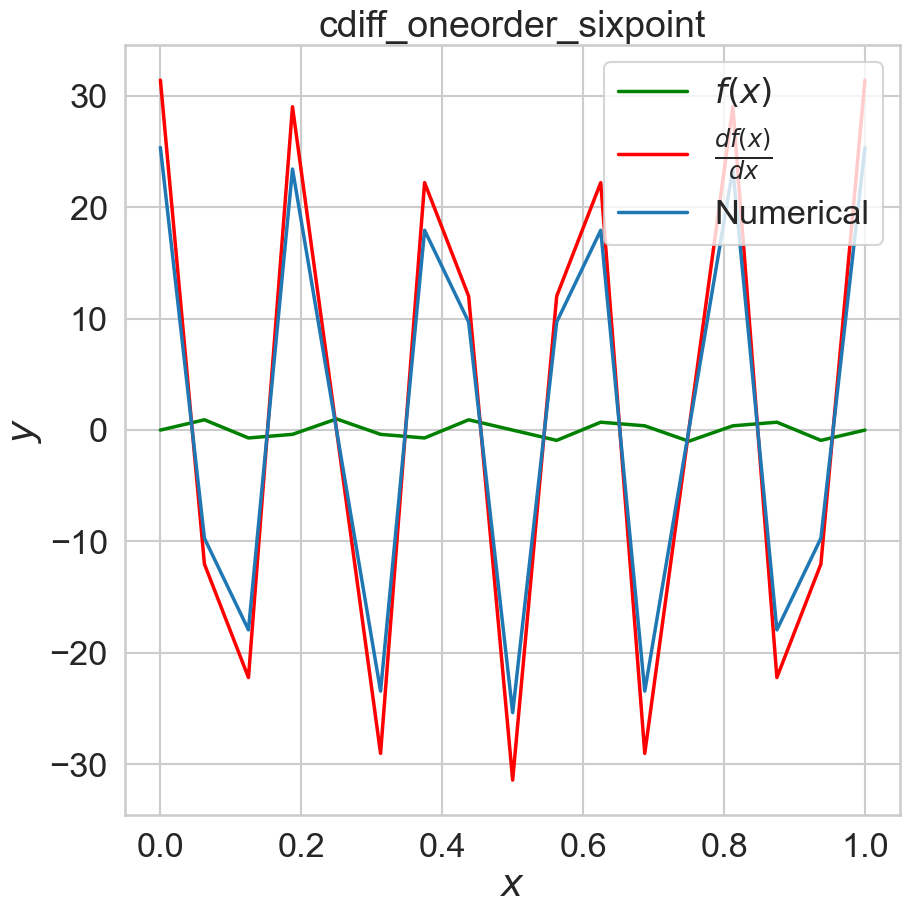

In [18]:
fig, ax = plt.subplots(1,1, figsize=(10, 10))
si = SpatialDifferentiator(a, b, h)
si.set_forcing_function(periodic_func)
si.diff_using(cdiff_oneorder_sixpoint, ax)

### Things to observe
- How does the relative error change when more point stencils are used?

## Other ways to approximate derivatives

Since we live in a periodic domain, we can spectrally differentiate functions using Fourier transforms. This is just for demonstration, and will not be covered in detail in the class.

In [19]:
def spectral_oneorder(func, x, h):
    # Evaluate function
    fx = func(x)[0]
    f_hat = np.fft.fft(fx)

    n_samples = x.shape[0]
    w_hat = 1j*np.zeros(n_samples)
    k_prefac = 2*np.pi/(n_samples*h)
    # 0 represents 0, then postive and then negative
    w_hat[:n_samples//2] = 1j*np.arange(0, n_samples//2, 1)*k_prefac
    # Middle one is zero, so leave as is
    w_hat[n_samples//2:] = 1j*np.arange(-n_samples//2, 0, 1)*k_prefac

    df_dx_hat = w_hat*f_hat
    df_dx = np.real(np.fft.ifft(df_dx_hat))
    
    return df_dx

In [20]:
# Bounds and step size
a = 0
b = 1
h = (b-a)/16

1.6113610465385801e-15

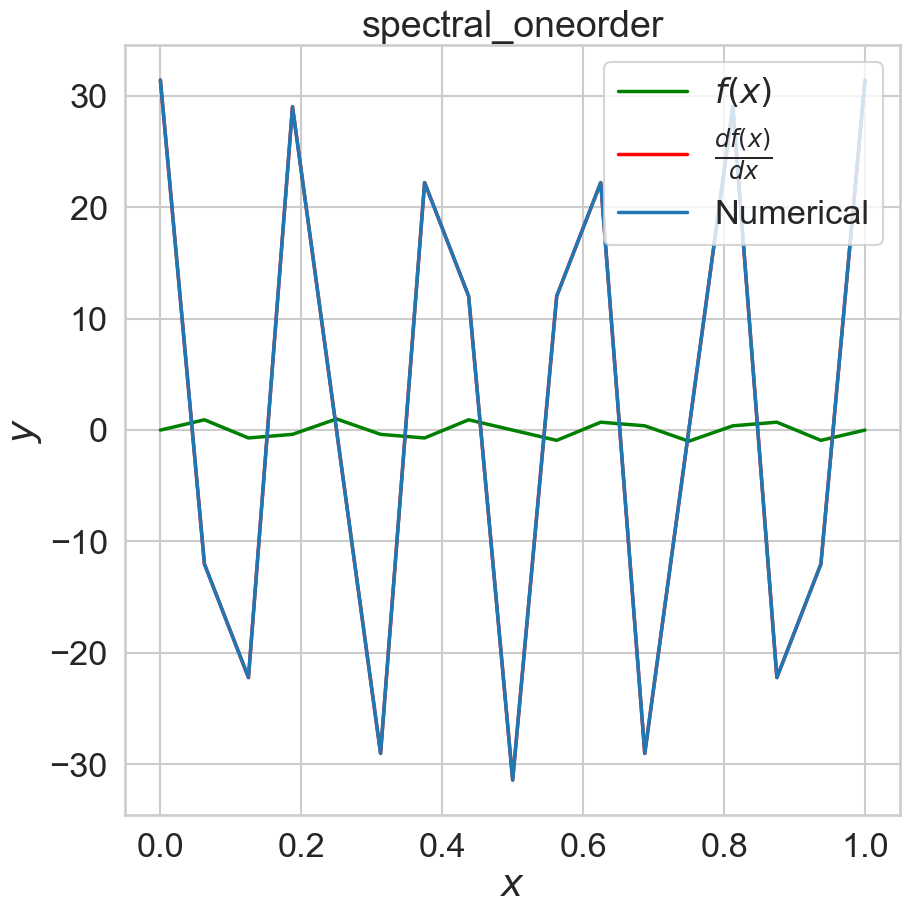

In [21]:
fig, ax = plt.subplots(1,1, figsize=(10, 10))
si = SpatialDifferentiator(a, b, h)
si.set_forcing_function(periodic_func)
si.diff_using(spectral_oneorder, ax)

Isn't that awesome?

## Order of accuracy of finite-difference schemes
What's **order** of accuracy? Order of accuracy quantifies the rate of convergence of a numerical approximation of a differential to the exact differential.
The numerical solution ${u}$ is said to be $n^{\text{th}}$-order accurate if the error, $e(h):=\lVert\tilde{{u}}-{u} \rVert$ is proportional to the discretization-size $ h $, to the $n^{\text{th}}$ power. That is

$$ e(h)=\lVert\tilde{{u}}-{u} \rVert\leq C(h)^{n} $$

Details of this are given in the slides. Here, we focus on differentiating a periodic function and figure out the order of convergence. The model problem that we deal with is to find
$$ y = \frac{d \sin(2\pi kx)}{dx} $$
which as we know has the analytical solution $ \tilde{y} = 2\pi k \cdot \cos(2\pi kx) $, and so error can be calculated.

In [22]:
a = 0
b = 1

# All functions that you coded up
impl_list = [fdiff_oneorder_twopoint, bdiff_oneorder_twopoint, cdiff_oneorder_twopoint, fdiff_oneorder_sixpoint, bdiff_oneorder_sixpoint, cdiff_oneorder_sixpoint, spectral_oneorder]
# impl_list = [fdiff_oneorder_twopoint, bdiff_oneorder_twopoint, cdiff_oneorder_twopoint]
# impl_list = [fdiff_oneorder_twopoint, bdiff_oneorder_twopoint, cdiff_oneorder_twopoint, fdiff_oneorder_sixpoint, bdiff_oneorder_sixpoint, cdiff_oneorder_sixpoint]

# Time steps and associated errors from 2^0 to 2^(-10)
h_steps = np.arange(1, 12, dtype=np.int16)
errors_list = [[None for i in h_steps] for impl in impl_list]

# Run simulations and collect errors
for i_impl, impl in enumerate(impl_list):
    for i_step, step in enumerate(h_steps):
        new_h = (b-a)/(8*(step))
        si = SpatialDifferentiator(a, b, new_h)
        si.set_forcing_function(periodic_func)
        errors_list[i_impl][i_step] = si.diff_using(impl, ax)

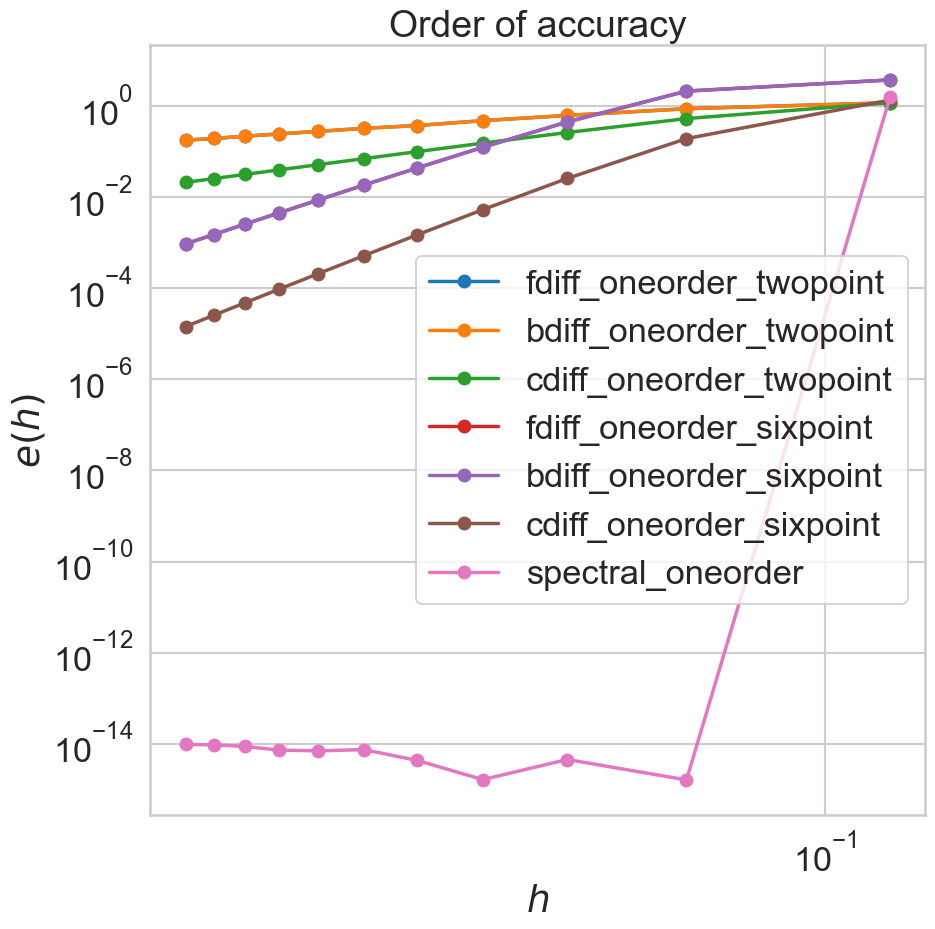

In [23]:
# Draw error plots in a log-log plot
fig, ax = plt.subplots(1,1, figsize=(10, 10))

# x axis is time, y axis is error
for i_impl, impl in enumerate(impl_list):
    ax.plot((b-a)/(8.*h_steps), errors_list[i_impl], 'o-', label=impl.__name__)

# Draw helpful slope lines to compare
# x_ax = (b-a)/(8.*h_steps)
# ax.plot(x_ax, 1.2 * x_ax**2, 'k--')
# ax.plot(x_ax, 0.5 * x_ax**2, 'k--')
# ax.plot(x_ax, 0.015 * x_ax**4, 'k--')  

# Make it readable
ax.set_xlabel(r'$h$')
ax.set_ylabel(r'$e(h)$')
ax.set_title('Order of accuracy')
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(loc='best')
# fig.savefig('ooa.pdf')

In [24]:
a = np.array([1.0, 2.0, 3.0, 4.0, 5.0])

In [25]:
a

array([1., 2., 3., 4., 5.])

In [26]:
aplusone = np.roll(a, -1)
aplusone

array([2., 3., 4., 5., 1.])

In [27]:
np.roll(a, 1)

array([5., 1., 2., 3., 4.])

In [28]:
a = np.array([1.0, 2.0, 3.0, 4.0, 5.0])
a

array([1., 2., 3., 4., 5.])

In [29]:
b = np.pad(a, (2,2), 'constant', constant_values=(10,15))
b

array([10., 10.,  1.,  2.,  3.,  4.,  5., 15., 15.])